<a href="https://colab.research.google.com/github/robertpetre/DSM/blob/main/DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cjinny/mura-v11")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/cjinny/mura-v11/versions/1


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import cv2
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
root_path = "/root/.cache/kagglehub/datasets/cjinny/mura-v11/versions/1/"

csv_path = os.path.join(root_path, "MURA-v1.1/train_image_paths.csv")
csv_path_test = os.path.join(root_path, "MURA-v1.1/valid_image_paths.csv")

df = pd.read_csv(csv_path)
df_test = pd.read_csv(csv_path_test)


filtered_df = df[df.iloc[:, 0].apply(lambda x: x.split("/")[2] == "XR_FOREARM")]
filtered_df_test = df_test[df_test.iloc[:, 0].apply(lambda x: x.split("/")[2] == "XR_FOREARM")]

filtered_dict = {
    image_path: 1 if "positive" in image_path else 0
    for image_path in filtered_df.iloc[:, 0]
}

filtered_dict_test = {
    image_path: 1 if "positive" in image_path else 0
    for image_path in filtered_df_test.iloc[:, 0]
}

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.GaussianBlur(image, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    image = np.uint8(np.absolute(sobel_edges))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    return image

In [ ]:
class BoneFracture(Dataset):
    def __init__(self, root_path, transform=None, preprocess=False):
        self.root_path = root_path
        self.transform = transform
        self.preprocess = preprocess
        self.dataset_dict = filtered_dict
        self.image_paths = list(self.dataset_dict.keys())
        self.labels = list(self.dataset_dict.values())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image_path = self.image_paths[idx]
      label = self.labels[idx]
      full_image_path = os.path.join(self.root_path, image_path)

      if self.preprocess:
          image = preprocess_image(full_image_path)
          image = Image.fromarray(image)
      else:
          image = Image.open(full_image_path).convert("L")

      # Apply transformations if any
      if self.transform:
          image = self.transform(image)  # Apply the transform

      return image, label

In [ ]:
train_dataset = BoneFracture(root_path=root_path, transform=transforms)
image_paths = train_dataset.image_paths
labels = train_dataset.labels

train_indices, val_indices = train_test_split(
    np.arange(len(image_paths)),
    test_size=0.2,
    stratify=labels
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_labels = [train_dataset.labels[idx] for idx in train_indices]
val_labels = [train_dataset.labels[idx] for idx in val_indices]

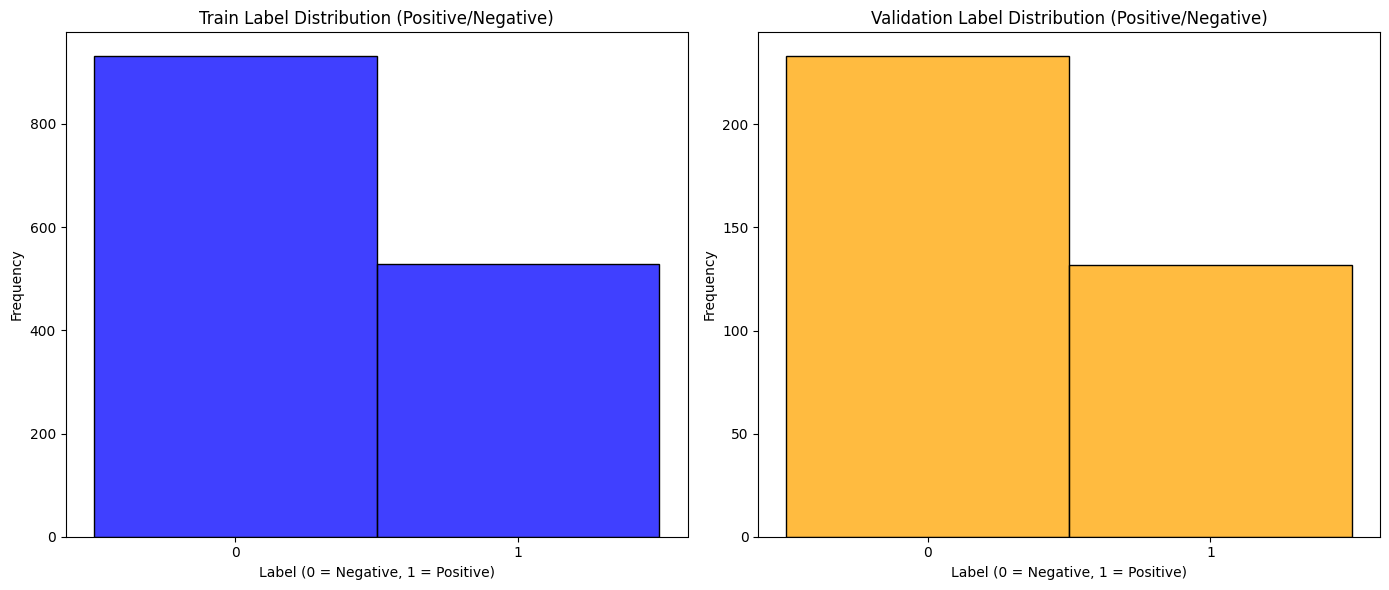

Train Label counts: Counter({0: 931, 1: 529})
Validation Label counts: Counter({0: 233, 1: 132})


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_labels, bins=2, kde=False, color='blue', discrete=True)
plt.title("Train Label Distribution (Positive/Negative)")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1])

plt.subplot(1, 2, 2)
sns.histplot(val_labels, bins=2, kde=False, color='orange', discrete=True)
plt.title("Validation Label Distribution (Positive/Negative)")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1])

plt.tight_layout()
plt.show()

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print(f"Train Label counts: {train_label_counts}")
print(f"Validation Label counts: {val_label_counts}")

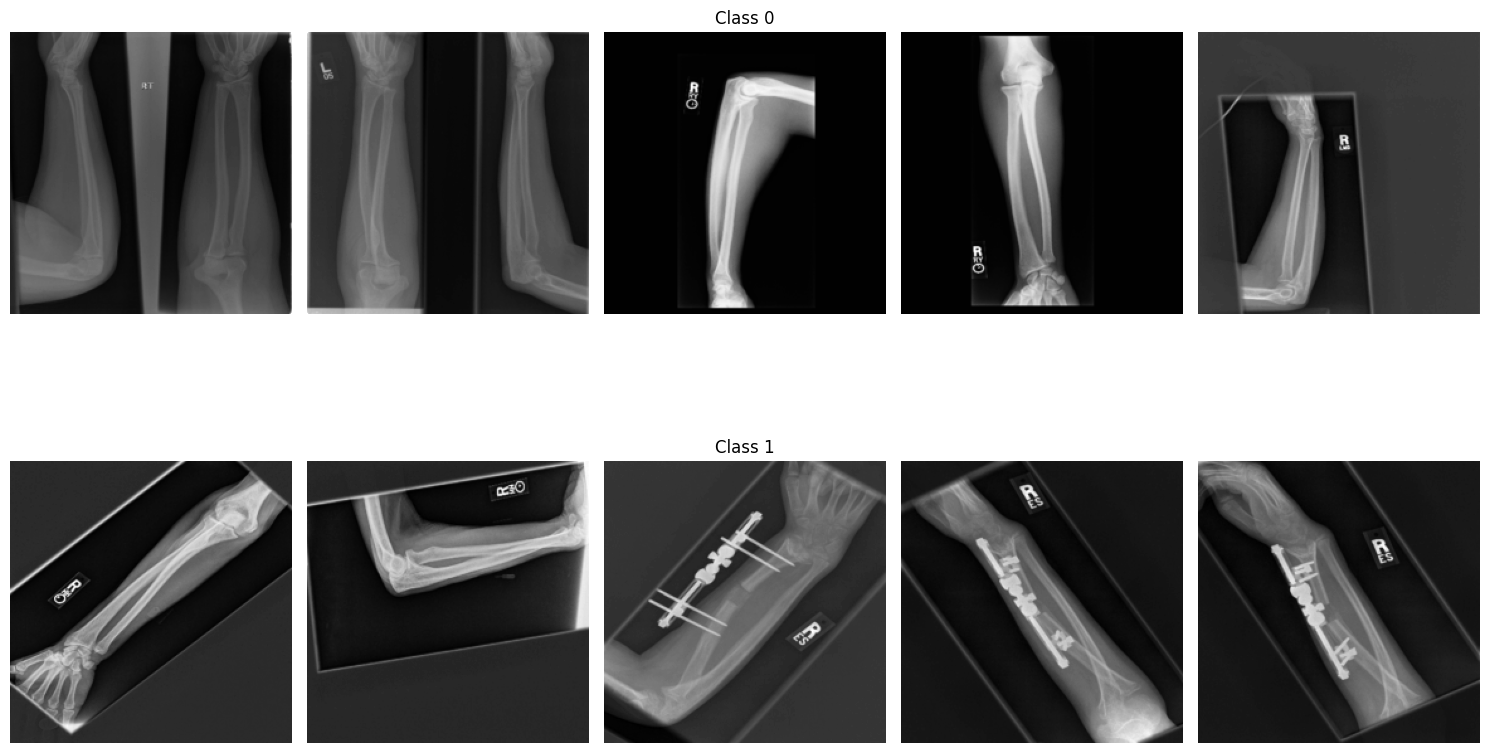

In [ ]:
def display_sample_images(dataset, num_classes, num_images_per_class=5):
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))

    class_images = {i: [] for i in range(num_classes)}
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        class_images[label].append(image)

    for i in range(num_classes):
        class_name = f"Class {i}"
        for j in range(num_images_per_class):
            if j < len(class_images[i]):
                image = class_images[i][j]

                image = image.permute(1, 2, 0).numpy()

                axes[i, j].imshow(image, cmap="gray")
                axes[i, j].axis('off')
                if j == 2:
                    axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

display_sample_images(train_dataset, num_classes=2)

In [ ]:
def check_image_modes(dataset):
    non_rgb_count = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)

        try:
            image = Image.open(full_image_path)
            if image.mode != "RGB":
                non_rgb_count += 1
        except FileNotFoundError:
            print(f"File not found: {full_image_path}")

    return non_rgb_count

non_rgb_train = check_image_modes(train_dataset)

print(f"Non-RGB images in training dataset: {non_rgb_train}")


Non-RGB images in training dataset: 678


In [ ]:
def square_images(dataset):
    count = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)
        image = Image.open(full_image_path)
        width, height = image.size
        if width != height:
            count += 1

    return count

train_non_square = square_images(train_dataset)

print(f"Non-square images in training dataset: {train_non_square}")

Non-square images in training dataset: 1735


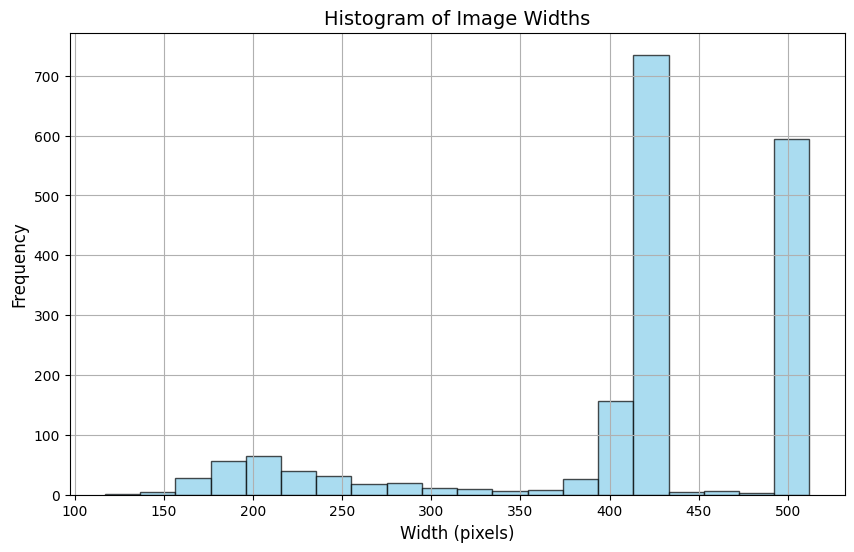

In [ ]:
def get_image_width(image_path):
    image = Image.open(image_path)
    return image.width

widths = []

for img_path in filtered_dict.keys():
    full_image_path = os.path.join(root_path, img_path)
    try:
        width = get_image_width(full_image_path)
        widths.append(width)
    except FileNotFoundError:
        print(f"File not found: {full_image_path}")
        continue

# Plot histogram of image widths
plt.figure(figsize=(10, 6))
plt.hist(widths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Image Widths', fontsize=14)
plt.xlabel('Width (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

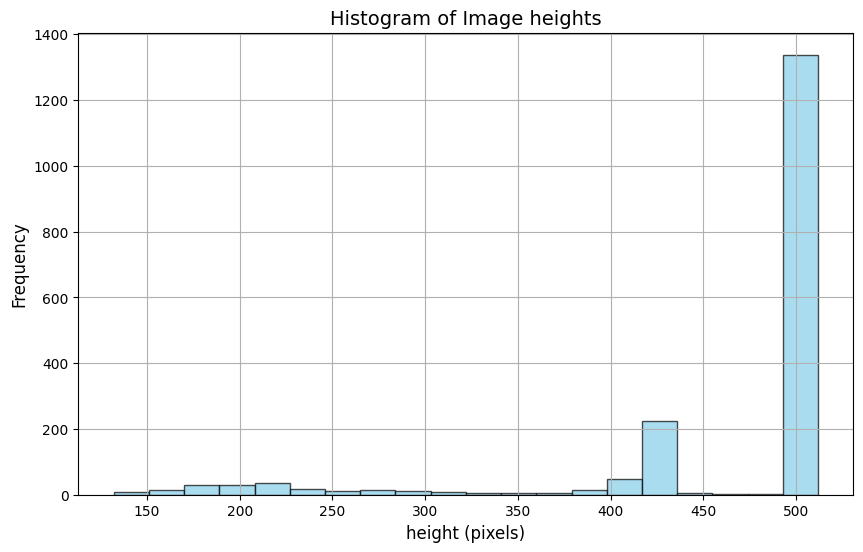

In [ ]:
def get_image_height(image_path):
    image = Image.open(image_path)
    return image.height

heights = []

for img_path in filtered_dict.keys():
    full_image_path = os.path.join(root_path, img_path)
    try:
        height = get_image_height(full_image_path)
        heights.append(height)
    except FileNotFoundError:
        print(f"File not found: {full_image_path}")
        continue

plt.figure(figsize=(10, 6))
plt.hist(heights, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Image heights', fontsize=14)
plt.xlabel('height (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
def img_pixel_range(dataset):
    min_val = 0
    max_val = 255
    count_images = 0
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        full_image_path = os.path.join(root_path, img_path)
        image = Image.open(full_image_path)
        image = np.array(image)
        if np.min(image) < min_val:
            count_images += 1
        if np.max(image) > max_val:
            count_images += 1

    return count_images

train_out_range = img_pixel_range(train_dataset)

print(f"Images with pixel values outside [0, 255] in training dataset: {train_out_range}")

Images with pixel values outside [0, 255] in training dataset: 0


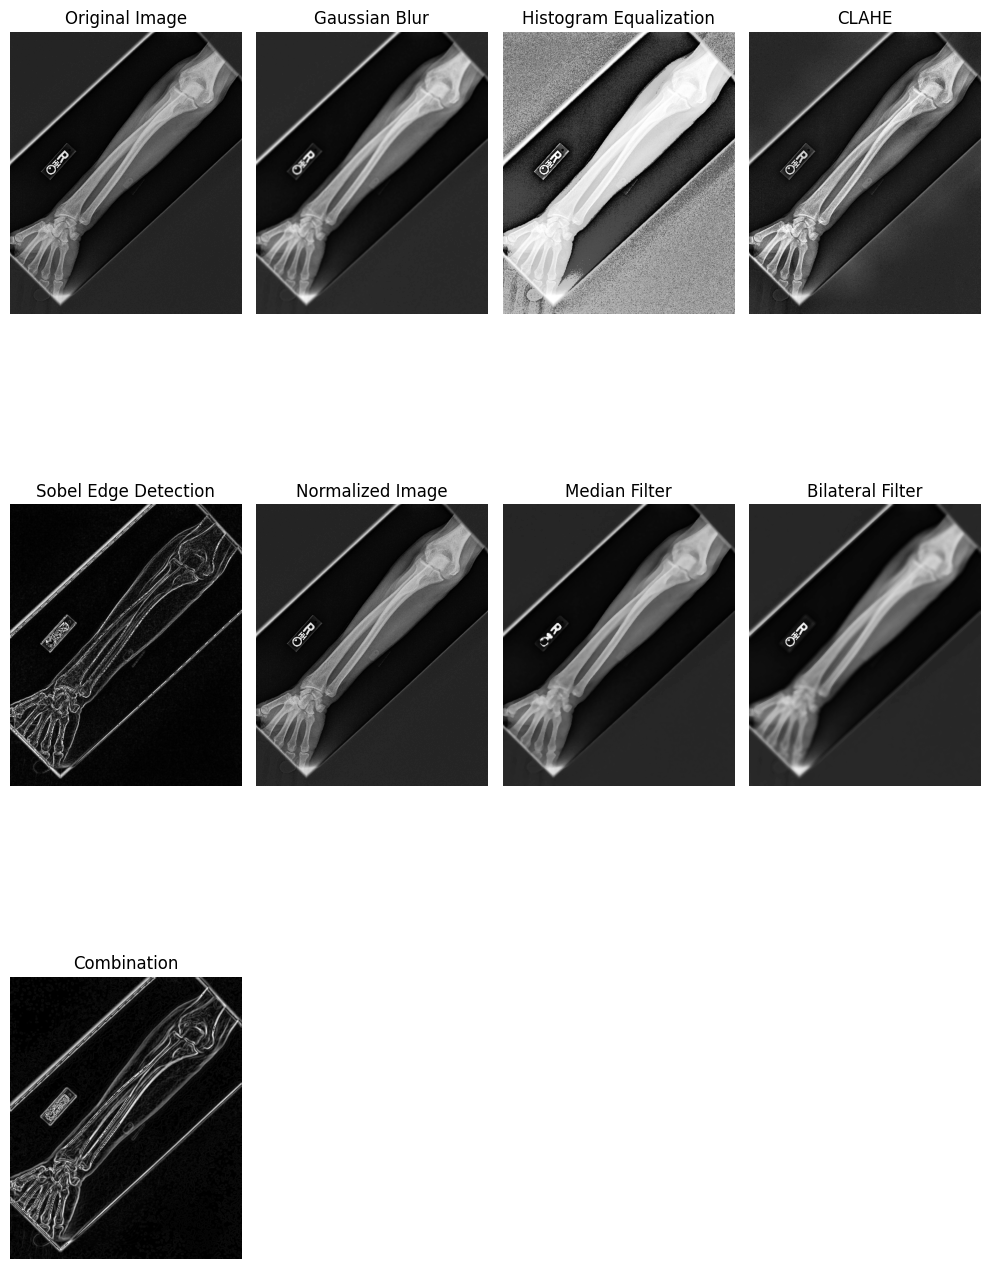

In [ ]:
# Get an image from the train dataset (adjust path accordingly)
image_path = os.path.join(root_path, train_dataset.image_paths[0])  # Adjust as necessary
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to display images
def display_images(images, titles, figsize=(10, 15)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(3, int(len(images) / 2), i+1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Image processing functions
def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def sobel_edge_detection(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    return np.uint8(np.absolute(sobel_edges))

def normalize_intensity(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def median_filter(image):
    return cv2.medianBlur(image, 5)

def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

# Apply different image processing techniques
gaussian_blurred = gaussian_blur(image)
hist_eq = histogram_equalization(image)
clahe_image = clahe(image)
sobel_edges = sobel_edge_detection(image)
normalized_image = normalize_intensity(image)
median_filtered = median_filter(image)
bilateral_filtered = bilateral_filter(image)

combination = gaussian_blur(image)
combination = clahe(combination)
combination = sobel_edge_detection(combination)
combination = normalize_intensity(combination)

# Collect all images
images = [
    image, gaussian_blurred, hist_eq, clahe_image, sobel_edges,
    normalized_image, median_filtered, bilateral_filtered, combination
]

# Titles for the images
titles = [
    'Original Image', 'Gaussian Blur', 'Histogram Equalization', 'CLAHE',
    'Sobel Edge Detection', 'Normalized Image', 'Median Filter', 'Bilateral Filter', 'Combination'
]

# Display the images
display_images(images, titles)

In [ ]:

use_cuda = torch.cuda.is_available()
device = "cuda"

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Define max pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        # Define fully connected layers
        # After 3 convolutions + pool, the size becomes (64 * 28 * 28) (for 224x224 input)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply convolution + ReLU + Pooling layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the tensor before the fully connected layers
        x = x.view(x.size(0), -1)  # Dynamically flatten the tensor

        # Apply fully connected layers with ReLU activation and dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
model = SimpleCNN(num_classes=2).to(device)

In [ ]:


model = SimpleCNN(2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
train_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)
val_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)
test_dataset = BoneFracture(root_path=root_path, transform=transforms, preprocess=True)

train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset.image_paths)),
    test_size=0.2,
    stratify=train_dataset.labels
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_epochs = 20
best_val_accuracy = 0.0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the correct device

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the correct device
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%")

100%|██████████| 46/46 [00:14<00:00,  3.11it/s]


Epoch [1/20], Train Loss: 0.6607, Train Accuracy: 62.33%, Val Loss: 0.6482, Val Accuracy: 63.84%


100%|██████████| 46/46 [00:13<00:00,  3.29it/s]


Epoch [2/20], Train Loss: 0.6518, Train Accuracy: 64.52%, Val Loss: 0.6354, Val Accuracy: 64.66%


100%|██████████| 46/46 [00:14<00:00,  3.26it/s]


Epoch [3/20], Train Loss: 0.6309, Train Accuracy: 65.55%, Val Loss: 0.6301, Val Accuracy: 66.03%


100%|██████████| 46/46 [00:14<00:00,  3.27it/s]


Epoch [4/20], Train Loss: 0.5997, Train Accuracy: 68.70%, Val Loss: 0.6476, Val Accuracy: 65.48%


100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Epoch [5/20], Train Loss: 0.5459, Train Accuracy: 71.44%, Val Loss: 0.6132, Val Accuracy: 68.22%


100%|██████████| 46/46 [00:13<00:00,  3.30it/s]


Epoch [6/20], Train Loss: 0.4801, Train Accuracy: 76.30%, Val Loss: 0.6354, Val Accuracy: 67.95%


100%|██████████| 46/46 [00:14<00:00,  3.25it/s]


Epoch [7/20], Train Loss: 0.4286, Train Accuracy: 80.00%, Val Loss: 0.7168, Val Accuracy: 67.67%


100%|██████████| 46/46 [00:14<00:00,  3.21it/s]


Epoch [8/20], Train Loss: 0.3295, Train Accuracy: 85.07%, Val Loss: 0.7965, Val Accuracy: 68.49%


100%|██████████| 46/46 [00:14<00:00,  3.18it/s]


Epoch [9/20], Train Loss: 0.2490, Train Accuracy: 89.86%, Val Loss: 0.9650, Val Accuracy: 65.75%


100%|██████████| 46/46 [00:14<00:00,  3.28it/s]


Epoch [10/20], Train Loss: 0.1985, Train Accuracy: 91.64%, Val Loss: 1.0548, Val Accuracy: 66.30%


100%|██████████| 46/46 [00:13<00:00,  3.34it/s]


Epoch [11/20], Train Loss: 0.1704, Train Accuracy: 93.15%, Val Loss: 1.2278, Val Accuracy: 67.95%


100%|██████████| 46/46 [00:13<00:00,  3.30it/s]


Epoch [12/20], Train Loss: 0.1482, Train Accuracy: 94.38%, Val Loss: 1.2089, Val Accuracy: 66.85%


100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


Epoch [13/20], Train Loss: 0.1147, Train Accuracy: 95.55%, Val Loss: 1.3169, Val Accuracy: 66.58%


100%|██████████| 46/46 [00:13<00:00,  3.31it/s]


Epoch [14/20], Train Loss: 0.0752, Train Accuracy: 96.92%, Val Loss: 1.4872, Val Accuracy: 63.56%


100%|██████████| 46/46 [00:14<00:00,  3.27it/s]


Epoch [15/20], Train Loss: 0.0832, Train Accuracy: 96.99%, Val Loss: 1.5587, Val Accuracy: 64.38%


100%|██████████| 46/46 [00:13<00:00,  3.31it/s]


Epoch [16/20], Train Loss: 0.0568, Train Accuracy: 97.33%, Val Loss: 1.7742, Val Accuracy: 64.93%


100%|██████████| 46/46 [00:13<00:00,  3.30it/s]


Epoch [17/20], Train Loss: 0.0595, Train Accuracy: 98.01%, Val Loss: 1.6397, Val Accuracy: 65.75%


100%|██████████| 46/46 [00:13<00:00,  3.30it/s]


Epoch [18/20], Train Loss: 0.0457, Train Accuracy: 98.36%, Val Loss: 2.0097, Val Accuracy: 65.75%


100%|██████████| 46/46 [00:14<00:00,  3.23it/s]


Epoch [19/20], Train Loss: 0.0464, Train Accuracy: 98.42%, Val Loss: 1.7691, Val Accuracy: 65.48%


100%|██████████| 46/46 [00:13<00:00,  3.30it/s]


Epoch [20/20], Train Loss: 0.0537, Train Accuracy: 98.22%, Val Loss: 1.8169, Val Accuracy: 64.93%


<ipython-input-85-c063ce516375>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Accuracy: 0.87, Precision: 0.88, Recall: 0.87, F1 Score: 0.87


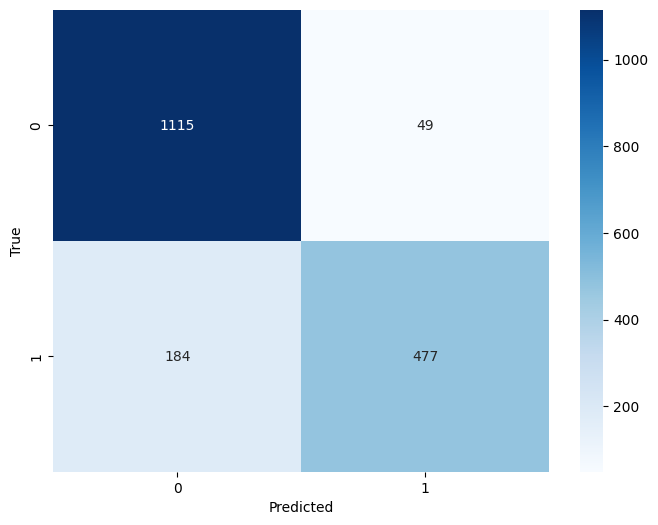

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


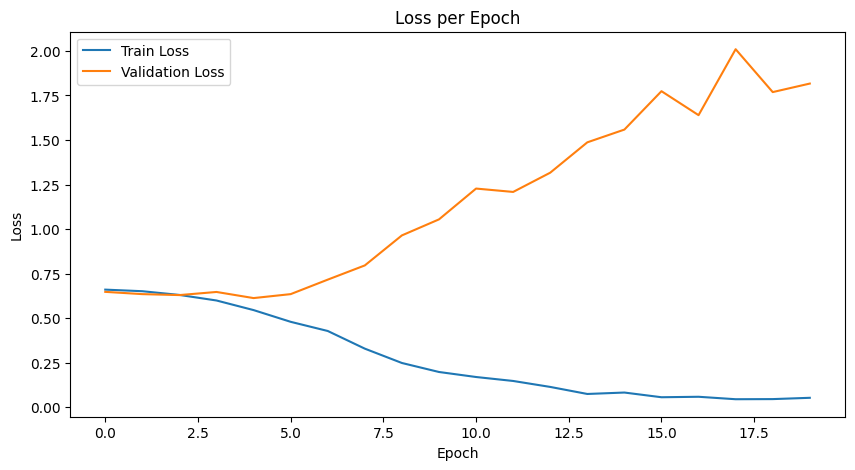

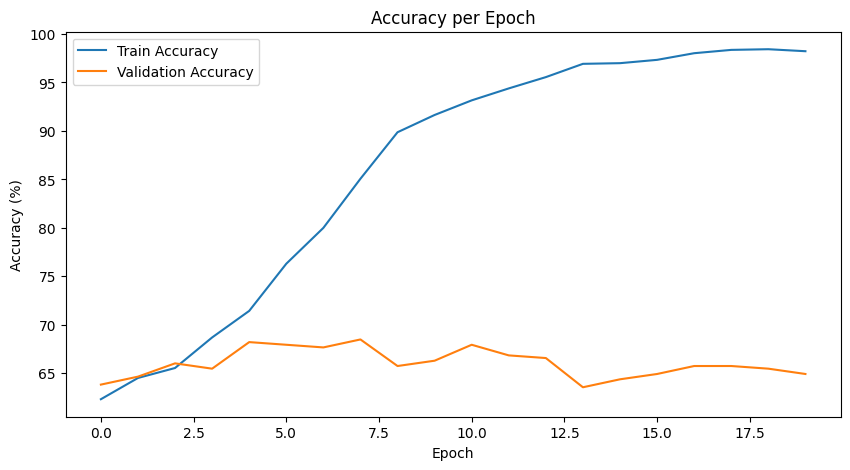

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()